In [1]:
import requests
import json
import scipy
# data manipulation
import numpy as np
import pandas as pd
#data visualization
import matplotlib.pyplot as plt 
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Transformando a 'HR_MEDICAO' que está em UTC para o correspondente para o BRASIL.
# Sendo a hora 0 = 21h.
# Criando uma coluna ['HR'] para esses valores

def hora_UTC(df):
    hora_br = 0
    HORA=[]

    for hora in df['HR_MEDICAO']:
        if hora/100+21 >= 25:
            hora_br = (hora/100+21)-24
        else:
            hora_br = hora/100+21
        HORA.append(hora_br)
    df.loc[:,'HORA'] = HORA    
    return df['HORA']

In [3]:
#verifica nulos
def p_null(df):
    """
    Mostra as colunas que tem null e que não tem e suas porcentagens.
    """
    for column in df.columns:
        if df[column].isnull().sum()==0:
            print(f'No null in column: {column}')
        else:
            print(f'Null in column: {column}')
    print( )
    print('The columns with the most % nulls are:')
    print(((df.isnull().sum()/df.shape[0])*100).sort_values(ascending = False))

In [4]:
#Zera a radiação do período com rad negativa (noite)
def treat_null_RAD2(df):
    condiction = df.loc[:,'RAD_GLO'] < 0                   # condição se o horário é mais que 21h
    df.loc[:,'RAD']  = np.where(condiction, 0.0 ,df.loc[:,'RAD_GLO'])
    condiction2 = df.loc[:,'HORA'] <= 6.0                 # condição se o horário é menos que 5h
    df['RAD']  = np.where(condiction2, 0.0 ,df['RAD'])
    df['RAD']  = df['RAD_GLO'].apply(lambda x: 0.0 if x < 0 else x) # ou se negativo é igual a zero
    return df.head()

In [5]:
def plot_time_series(x, y, 
                     titulo = 'Série temporal',
                     titulo_xlabel = 'Time',
                     titulo_ylabel = 'Valores'
                    ):
    """
    Faz um gráfico de linhas a partir de valores para os eixos x e y.
    Args:
        x: array com o range de datas, para um DataFrame selecione usando o atributo .index
        y: arrays com os valores da série temporal
        titulo: título da figura
        titulo_xlabel: título do eixo x
        titulo_ylabel: título do eixo y
    """
    # range mínimo e máximo do recorte temporal
    time_min = x.min()
    time_max = x.max()
    # configurações da fonte para os eixos
    font_labels = {
        'color': 'gray',
        'size': 10,
        'weight': 'normal',
    }
    # tamanho da figura
    plt.figure(figsize = (14, 5))
    # insere a linha no plot
    # no eixo x inserimos o tempo e no eixo y os valores da série temporal
    plt.plot(x, y, color = 'black')
    # título da figura
    plt.title(titulo, fontsize = 12, fontweight = 'bold')
    # rótulos dos eixos x e y
    plt.xlabel(titulo_xlabel, fontdict = font_labels)
    plt.ylabel(titulo_ylabel, fontdict = font_labels)
    # gridlines
    plt.grid(axis = 'both', alpha = 0.5)
    # limites do eixo x
    plt.xlim([time_min.date(), time_max.date()])
    plt.show()

In [6]:
#Ho: Não é estacionário
#H1: É estacionário

def adfuller_test(Vendas):
    
    result=adfuller(Vendas)
    
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
   
    # se a significância estiver abaixo de 0.05, significa que há pouca influência nos dados. 
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis, indicating it is non-stationary ")

# scraping

In [7]:
# Pegando os dados utilizando o API do inmet a partir do site acima

#Para pegar dados das estações automáticas
url=requests.get('https://apitempo.inmet.gov.br/estacoes/T')
x=url.json()
df_estacoes_full=pd.read_json(json.dumps(x))

In [8]:
# Iremos escolher apenas algumas das estações.
LISTA_ESTACOES = ['SAO PAULO - MIRANTE']

In [9]:
#Filtrando apenas as estações da lista e as colunas necessárias
df_estacoes_filter = pd.DataFrame()
for estacoes in LISTA_ESTACOES:
    filtro = 'DC_NOME == "' + estacoes + '"'
    df_estacoes_filter = df_estacoes_filter.append(df_estacoes_full.query(filtro))
df_estacoes_filter = df_estacoes_filter[['DC_NOME','CD_ESTACAO','VL_LATITUDE','VL_ALTITUDE','VL_LONGITUDE']]

In [10]:
#selecionar os códigos da estações e o intevalo de data escolhida
lista_cd_estacao = df_estacoes_filter.CD_ESTACAO.unique()
data_inicial = '2015-01-01'
data_final = '2021-12-31'

In [11]:
#Scraping dos dados das estações pego anteriormente
df = pd.DataFrame()
for x in lista_cd_estacao:
    url = requests.get(f'https://apitempo.inmet.gov.br/estacao/{data_inicial}/{data_final}/{x}')
    x = url.json()
    df = df.append(pd.read_json(json.dumps(x)))

In [12]:
df.dtypes

DC_NOME          object
PRE_INS         float64
TEM_SEN         float64
VL_LATITUDE     float64
PRE_MAX         float64
UF               object
RAD_GLO         float64
PTO_INS         float64
TEM_MIN         float64
VL_LONGITUDE    float64
UMD_MIN         float64
PTO_MAX         float64
VEN_DIR         float64
DT_MEDICAO       object
CHUVA           float64
PRE_MIN         float64
UMD_MAX         float64
VEN_VEL         float64
PTO_MIN         float64
TEM_MAX         float64
VEN_RAJ         float64
TEM_INS         float64
UMD_INS         float64
CD_ESTACAO       object
HR_MEDICAO        int64
dtype: object

In [14]:
# verifica o percentual de missing data
p_null(df)

No null in column: DC_NOME
Null in column: PRE_INS
Null in column: TEM_SEN
No null in column: VL_LATITUDE
Null in column: PRE_MAX
No null in column: UF
Null in column: RAD_GLO
Null in column: PTO_INS
Null in column: TEM_MIN
No null in column: VL_LONGITUDE
Null in column: UMD_MIN
Null in column: PTO_MAX
Null in column: VEN_DIR
No null in column: DT_MEDICAO
Null in column: CHUVA
Null in column: PRE_MIN
Null in column: UMD_MAX
Null in column: VEN_VEL
Null in column: PTO_MIN
Null in column: TEM_MAX
Null in column: VEN_RAJ
Null in column: TEM_INS
Null in column: UMD_INS
No null in column: CD_ESTACAO
No null in column: HR_MEDICAO

The columns with the most % nulls are:
RAD_GLO         1.533372
TEM_SEN         0.902751
VEN_VEL         0.901121
PTO_MIN         0.241168
PTO_MAX         0.237909
PTO_INS         0.236279
CHUVA           0.236279
TEM_MIN         0.234650
TEM_MAX         0.234650
UMD_MAX         0.234650
UMD_MIN         0.234650
UMD_INS         0.233020
VEN_DIR         0.231391
PRE

In [15]:
#trasformando a data em datetime
df.loc[:,'DT_MEDICAO'] =  pd.to_datetime(df.loc[:,'DT_MEDICAO'], format='%Y-%m-%d')

In [16]:
hora_UTC(df)

0        21.0
1        22.0
2        23.0
3        24.0
4         1.0
         ... 
61363    16.0
61364    17.0
61365    18.0
61366    19.0
61367    20.0
Name: HORA, Length: 61368, dtype: float64

In [17]:
# quantidade de linhas e a colunas
df.shape

(61368, 26)

In [18]:
#Completar a chuva com 0.
df.loc[:,'CHUVA'].fillna(0.0, inplace=True)

In [19]:
#zera a radiação nos períodos com rad negativa
treat_null_RAD2(df)

,DC_NOME,PRE_INS,TEM_SEN,VL_LATITUDE,PRE_MAX,UF,RAD_GLO,PTO_INS,TEM_MIN,VL_LONGITUDE,...,VEN_VEL,PTO_MIN,TEM_MAX,VEN_RAJ,TEM_INS,UMD_INS,CD_ESTACAO,HR_MEDICAO,HORA,RAD
0,SAO PAULO - MIRANTE,925.5,25.1,-23.496294,925.5,SP,-3.54,16.8,25.5,-46.620088,...,1.7,16.4,25.7,5.7,25.5,59.0,A701,0,21.0,0.0
1,SAO PAULO - MIRANTE,926.0,25.5,-23.496294,926.0,SP,-3.54,15.7,25.4,-46.620088,...,0.8,15.2,25.9,4.8,25.4,55.0,A701,100,22.0,0.0
2,SAO PAULO - MIRANTE,925.5,25.1,-23.496294,926.0,SP,-3.54,15.7,25.4,-46.620088,...,1.6,15.4,25.8,5.1,25.7,54.0,A701,200,23.0,0.0
3,SAO PAULO - MIRANTE,925.0,24.5,-23.496294,925.5,SP,-3.54,16.5,25.3,-46.620088,...,2.0,15.3,25.7,4.9,25.3,58.0,A701,300,24.0,0.0
4,SAO PAULO - MIRANTE,924.5,24.3,-23.496294,925.0,SP,-3.54,17.2,25.0,-46.620088,...,2.1,16.5,25.4,4.4,25.0,62.0,A701,400,1.0,0.0


In [30]:
df_ts=df[['DT_MEDICAO','HORA','RAD','CHUVA']]

In [31]:
df_ts.head(24)

,DT_MEDICAO,HORA,RAD,CHUVA
0,2015-01-01,21.0,0.000,0.0
1,2015-01-01,22.0,0.000,0.0
2,2015-01-01,23.0,0.000,0.0
3,2015-01-01,24.0,0.000,0.0
4,2015-01-01,1.0,0.000,0.0
5,2015-01-01,2.0,0.000,0.0
6,2015-01-01,3.0,0.000,0.0
7,2015-01-01,4.0,0.000,0.0
8,2015-01-01,5.0,0.000,0.0
9,2015-01-01,6.0,115.361,0.0


In [32]:
# verifica o percentual de missing data
p_null(df_ts)

No null in column: DT_MEDICAO
No null in column: HORA
Null in column: RAD
No null in column: CHUVA

The columns with the most % nulls are:
RAD           1.533372
CHUVA         0.000000
HORA          0.000000
DT_MEDICAO    0.000000
dtype: float64


In [33]:
df_ts['HORA'] = df_ts['HORA'].astype(int)

<ipython-input-33-bc5b768c6d67>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts['HORA'] = df_ts['HORA'].astype(int)


In [240]:
#ts=ts.astype({'HORA':'string'})

In [199]:
#ts['HORA']=ts['HORA'].str.rstrip('.0')

In [34]:
df_ts.loc[df_ts["HORA"] == 24, "HORA"] = 0

C:\Users\vhide\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [36]:
df_ts=df_ts.astype({'HORA':'string'})

In [37]:
df_ts['HORA']=df_ts['HORA'] + ':00:00'

In [38]:
df_ts=df_ts.astype({'DT_MEDICAO':'string'})

In [39]:
df_ts['DT_MEDICAO']=df_ts['DT_MEDICAO']+ ' '+df_ts['HORA']

In [40]:
pd.to_datetime(df_ts['DT_MEDICAO'])

0       2015-01-01 21:00:00
1       2015-01-01 22:00:00
2       2015-01-01 23:00:00
3       2015-01-01 00:00:00
4       2015-01-01 01:00:00
                ...        
61363   2021-12-31 16:00:00
61364   2021-12-31 17:00:00
61365   2021-12-31 18:00:00
61366   2021-12-31 19:00:00
61367   2021-12-31 20:00:00
Name: DT_MEDICAO, Length: 61368, dtype: datetime64[ns]

In [41]:
df_ts.drop(columns=['HORA'], inplace=True)

In [42]:
df_ts.set_index('DT_MEDICAO', drop=True, inplace=True)
df_ts.index = pd.DatetimeIndex(df_ts.index)

In [43]:
df_ts.head(24)

,RAD,CHUVA
DT_MEDICAO,,
2015-01-01 21:00:00,0.000,0.0
2015-01-01 22:00:00,0.000,0.0
2015-01-01 23:00:00,0.000,0.0
2015-01-01 00:00:00,0.000,0.0
2015-01-01 01:00:00,0.000,0.0
2015-01-01 02:00:00,0.000,0.0
2015-01-01 03:00:00,0.000,0.0
2015-01-01 04:00:00,0.000,0.0
2015-01-01 05:00:00,0.000,0.0


In [44]:
ts_chuva=df_ts.drop(columns=["RAD"])
ts_rad=df_ts.drop(columns=["CHUVA"])

# Chuva

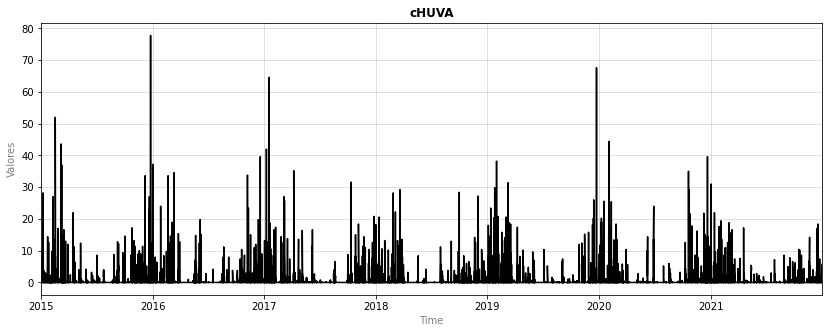

In [47]:
# evolução da série temporal da chuva
plot_time_series(ts_chuva.index, ts_chuva.values, titulo = 'cHUVA')

<AxesSubplot:xlabel='DT_MEDICAO'>

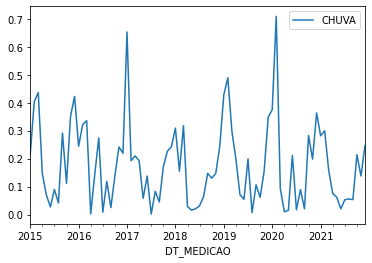

In [48]:
# obtém a série em observação média mensal
ts_chuva.resample('M').mean().plot()

<AxesSubplot:xlabel='DT_MEDICAO'>

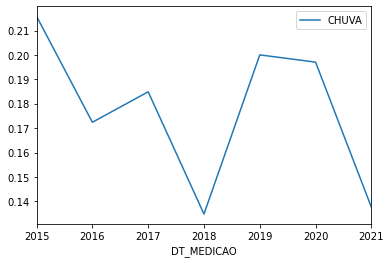

In [49]:
# obtém a série em observação média anual
ts_chuva.resample('Y').mean().plot()

<AxesSubplot:>

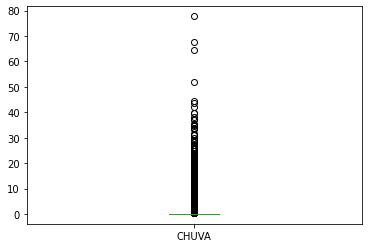

In [51]:
# boxplot
ts_chuva.plot(kind = 'box')

In [ ]:
#agrupar por dia

In [57]:
adfuller_test(ts_chuva)

ADF Test Statistic : -39.30949890897561
p-value : 0.0
#Lags Used : 26
Number of Observations Used : 61341
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


<ipython-input-58-04608877d467>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(ts_chuva, freq=365)


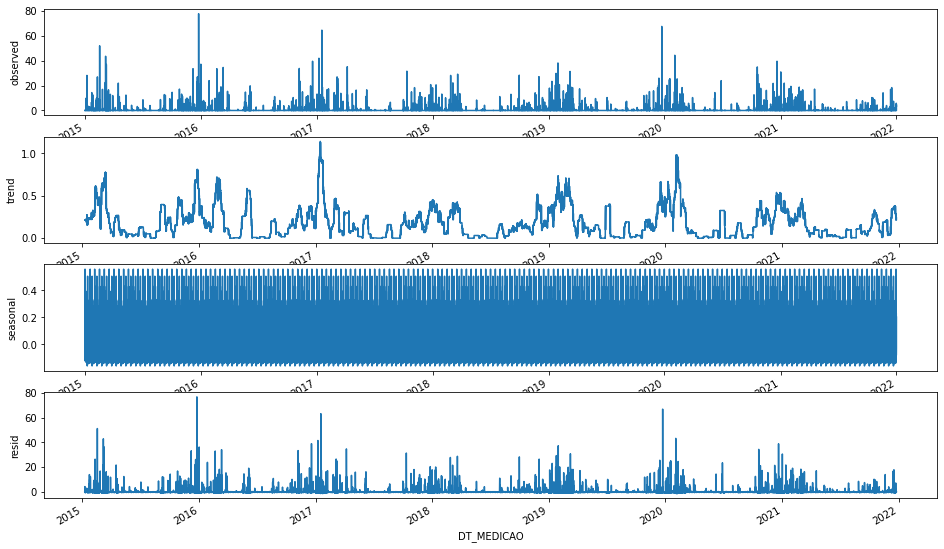

In [58]:
# Vamos realizar uma decomposição aditiva da nossa série, e estudar sua tendência, sazonalidade e resíduo.
decomposition = seasonal_decompose(ts_chuva, freq=365)

fig, ax = plt.subplots(4, 1, figsize=(16, 10))
decomposition.observed.plot(ax=ax[0]); ax[0].set_ylabel('observed')
decomposition.trend.plot(ax=ax[1]); ax[1].set_ylabel('trend')
decomposition.seasonal.plot(ax=ax[2]); ax[2].set_ylabel('seasonal')
decomposition.resid.plot(ax=ax[3]); ax[3].set_ylabel('resid');

# Radiacao

In [278]:
#df com rad >0
ts_hr_rad=ts.loc[ts['RAD'] > 0]

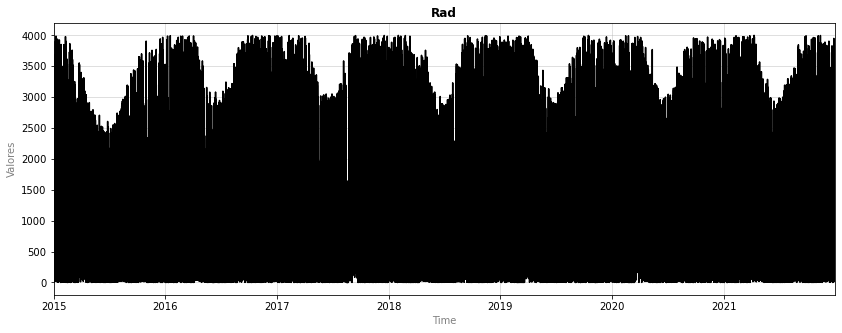

In [282]:
# evolução da série temporal
plot_time_series(ts_hr_rad.index, ts_hr_rad.values, titulo = 'Rad')

<AxesSubplot:xlabel='DT_MEDICAO'>

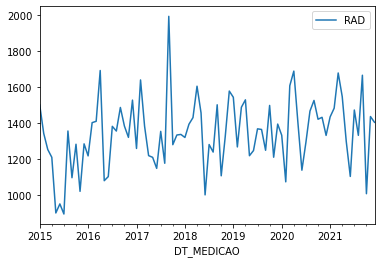

In [292]:
# obtém a série em observação média mensal
ts_hr_rad.resample('M').mean().plot()

<AxesSubplot:xlabel='DT_MEDICAO'>

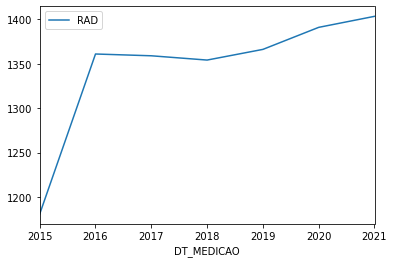

In [293]:
# obtém a série em observação média anual
ts_hr_rad.resample('Y').mean().plot()

array([[<AxesSubplot:title={'center':'RAD'}>]], dtype=object)

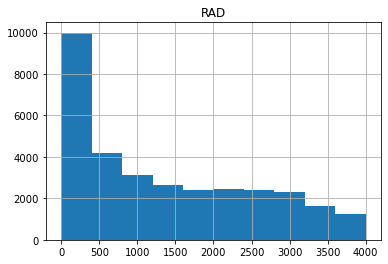

In [294]:
# distribuição da série
ts_hr_rad.hist()

<AxesSubplot:ylabel='Density'>

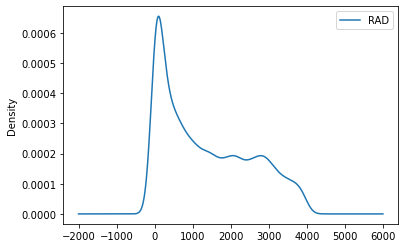

In [295]:
# densidade
ts_hr_rad.plot(kind = 'kde')

<AxesSubplot:>

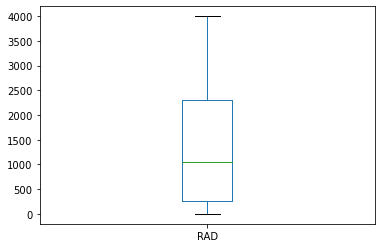

In [296]:
# boxplot
ts_hr_rad.plot(kind = 'box')

In [301]:
adfuller_test(ts_hr_rad)

ADF Test Statistic : -21.462406973725038
p-value : 0.0
#Lags Used : 50
Number of Observations Used : 32247
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


<ipython-input-311-e84e245fea6e>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(ts_hr_rad, freq=365)


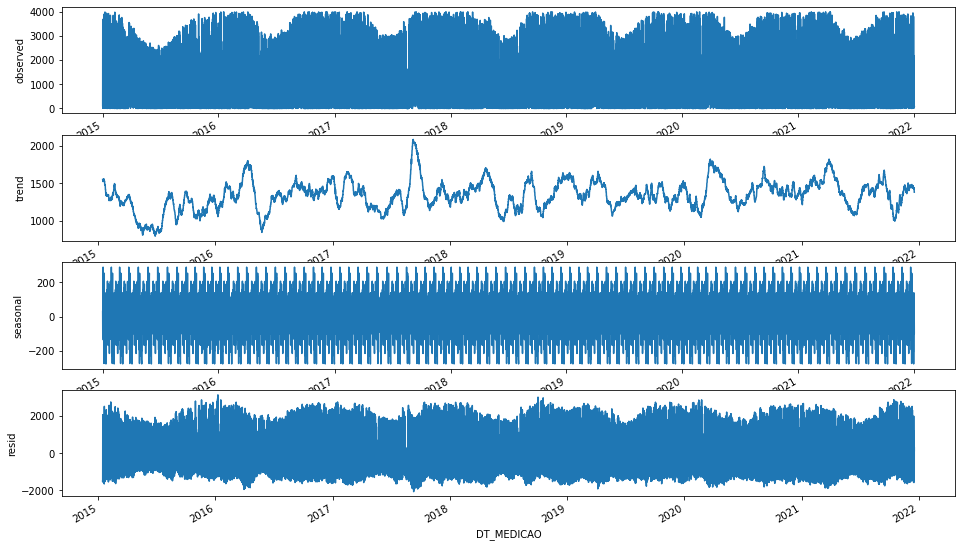

In [311]:
# Vamos realizar uma decomposição aditiva da nossa série, e estudar sua tendência, sazonalidade e resíduo.
decomposition = seasonal_decompose(ts_hr_rad, freq=365)

fig, ax = plt.subplots(4, 1, figsize=(16, 10))
decomposition.observed.plot(ax=ax[0]); ax[0].set_ylabel('observed')
decomposition.trend.plot(ax=ax[1]); ax[1].set_ylabel('trend')
decomposition.seasonal.plot(ax=ax[2]); ax[2].set_ylabel('seasonal')
decomposition.resid.plot(ax=ax[3]); ax[3].set_ylabel('resid');

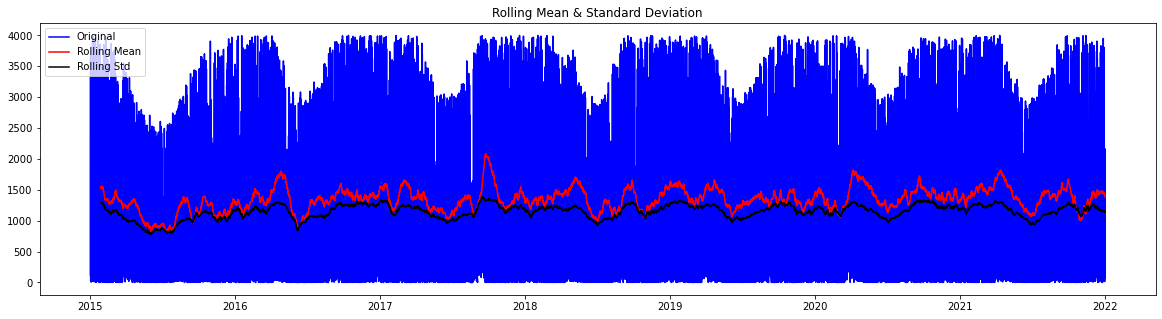

In [312]:
#Determing rolling statistics
rolmean = ts_hr_rad.rolling(365).mean()
rolstd = ts_hr_rad.rolling(365).std()

#Plot rolling statistics:
plt.figure(figsize = (20, 5))
orig = plt.plot(ts_hr_rad, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

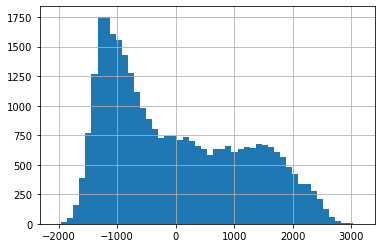

In [313]:
# Vamos analisar a componente de resíduo com um pouco mais de cuidado:
decomposition.resid.hist(bins=50);

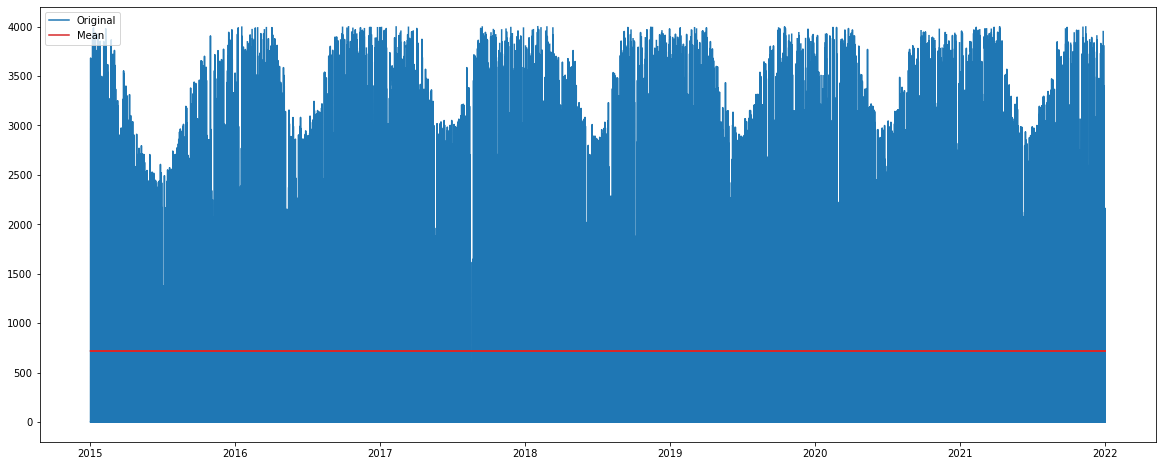

In [316]:
# Será q a média consegue descrever bem nossa distribuição?
plt.figure(figsize=(20, 8))
plt.plot(ts, color='C0',label='Original')
plt.plot(ts.index, [ts['RAD'].mean() for _ in ts.index], label=f'Mean', c='C03');
plt.legend();